### Simulation: Statistics for N speckle patterns

In [1]:
from matplotlib import pyplot as plt
import matplotlib as mpl
# matplotlib.rcParams.update(matplotlib.rcParamsDefault)
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import math
import sys
import time
import os
import h5py
import sympy
import pandas as pd
from datetime import date
from tqdm import tqdm

In [2]:
## the defalt path is ".../code". Need to go to upper directory for parent_dir
os.path.abspath('')
code_dir = "%s/"%os.getcwd()
parent_dir = code_dir.replace('code/','')
function_dir = parent_dir + 'functions/'
data_dir = parent_dir + 'data/'
fig_dir = parent_dir + 'figures/'
sys.path.insert(0,parent_dir)

In [3]:
## import coustom functions
import functions.f_complex_phasor_hsl_v1 as chsl
import functions.fbasis_functions_all_v4 as funs_v4
import functions.fbasis_functions_simulation_only_v1 as funs_sim

In [4]:
## functions
def imag_linear2log_v1(c1,c2,input):
    Ny,Nx = np.shape(input)
    input_mag = np.abs(input)
    in_max = np.max(input_mag)
    out_log = c1*np.log(1+c2*input)/np.log(1+c2*in_max)
    out_log_imag = np.zeros([Ny,Nx])
    out_log_imag[:,:] =out_log
    return out_log_imag 

In [5]:
## Load objects
RawI_dir = data_dir + "raw_image/"
imag1 = plt.imread(RawI_dir+"UCB_Seal_image_v1.png")
Robj1 = imag1[:,:,0]
Ny,Nx = np.shape(Robj1)

## High resolution case
# imag1 = plt.imread(RawI_dir+"UCB_Seal_image_v2.png")
# Ncrop = 3020
# Robj1 = imag1[0:Ncrop,0:Ncrop,0]
# Ny,Nx = np.shape(Robj1)

In [6]:
##Ideal uv-plane
uv1 = np.fft.fftshift(np.fft.fft2(Robj1))
c1 = 0.9
c2 = 0.01
uv1_log = imag_linear2log_v1(c1,c2,np.abs(uv1))
s0 = 0.9
l0 = 0.9
uv1_log_complex = uv1_log*np.exp(1j*np.angle(uv1))
uv1_hsl = chsl.hsl_complex_v1(s0,l0,uv1_log_complex)

In [7]:
## save randomized phase
# savepkl = False
# # Nrun = int(2**1)
# Nrun = int(2**7)

# rand_pkl_dir = data_dir + f"speckle_phase/{Nx}x{Ny}/"
# if savepkl:
#     if not os.path.exists(rand_pkl_dir):
#         os.makedirs(rand_pkl_dir)
# for irun in tqdm(range(2,Nrun)):
#     gamma_r = np.exp(-1j*2*np.pi*np.random.uniform(low=0.0, high=1.0, size=(Ny,Nx)))
#     pd.DataFrame(gamma_r).to_pickle(rand_pkl_dir + f"speckle_phase_run{irun}.pickle")

In [8]:
## load randomized phase
# rand_pkl_dir = data_dir + f"speckle_phase/{Nx}x{Ny}/"

# irun = 0
# gamma_r = np.array(pd.read_pickle(rand_pkl_dir+f"speckle_phase_run{irun}.pickle"))

# Nrun = 127
Nrun = 32

In [9]:
## amplitude distribution
# mgx = 0.5
# mgy = 0.5
mgx = .5
mgy = .5
wx = mgx*Nx
wy = mgy*Ny
x_au = np.linspace(-Nx/2,Nx/2,Nx)
y_au = np.linspace(-Ny/2,Ny/2,Ny)
X_au,Y_au = np.meshgrid(x_au,y_au)
gaus = np.exp(-X_au**2/wx**2 - Y_au**2/wy**2)

In [10]:
ShortFFT = True
p_seg = 1
Bandwidth = 10e6
StartFreq = 70e6
Min_grid = 1e2

if Bandwidth ==10E6:
    bw_str = "10MHz/"
elif Bandwidth == 20E6:
    bw_str = "20MHz/"
else:
    input("Bandwidth is not set to 10 or 20 MHz")

In [11]:
##Sampling rate for the time stamps
SampleFreq = 100e6

In [12]:
##Spatial dimensions and 2D grid
va = 600
Dfringes = 1/4.5e-3
Mag = Bandwidth/va/Dfringes
Factor_NySampling = 2
lbda = .5e-6
Dist = 1e2
Rx_Diameter = 25e-3

In [13]:
#Dimension setting: dimension choices: 2, 4, 5, 6, 8, 12, 16, 24, 32, 48
dimension_case = 1
if dimension_case == 1:
    dimension_all = np.array([16]).astype('int')
elif dimension_case == 2:
    dimension_all = np.array([24]).astype('int')

In [14]:
Phase_tone_case = 2

In [15]:
m_k = 0.1     ## scaled factor of the angle/k-vector
# m_k = 1     ## scaled factor of the angle/k-vector

In [16]:
## Receiver aperture
# D_cir = 200
# W_cir = np.zeros([Ny,Nx])
# W_cir[X_au**2+Y_au**2<(D_cir/2)**2] = 1

# angles = np.linspace(0,np.pi*4,400)
# x_rx = np.sin(angles)*D_cir/2+Nx/2
# y_rx = np.cos(angles)*D_cir/2+Ny/2

D_cir_all = 2**np.arange(3,8+1).astype('int')

In [17]:
for dimension_ind,dimension in enumerate(dimension_all):

    msr_Dcir = np.zeros(len(D_cir_all))

    for D_cir_ind in range(len(D_cir_all)):
        D_cir = D_cir_all[D_cir_ind]
        W_cir = np.zeros([Ny,Nx])
        W_cir[X_au**2+Y_au**2<(D_cir/2)**2] = 1

        angles = np.linspace(0,np.pi*4,400)
        x_rx = np.sin(angles)*D_cir/2+Nx/2
        y_rx = np.cos(angles)*D_cir/2+Ny/2

        if Phase_tone_case ==1:
            ##Case1: Zero phases
            Phase_signal = np.zeros((dimension,1))
            Phase_signal_x = Phase_signal
            Phase_signal_y = Phase_signal
            Phase_name = "ZeroPhases"
        elif Phase_tone_case==2:
            ##Case2: Random phases
            Name_Rx = f"{data_dir+'Phase_offset/'}Rand_phase_x_{dimension:.0f}Signals.mat"
            Name_Rx_hfile = h5py.File(Name_Rx, 'r')
            Phase_signal_x_h5 = Name_Rx_hfile.get("Phase_signal_x")
            Phase_signal_x = np.array(Phase_signal_x_h5)
            Name_Ry = f"{data_dir+'Phase_offset/'}Rand_phase_y_{dimension:.0f}Signals.mat"    
            Name_Ry_hfile = h5py.File(Name_Ry, 'r')
            Phase_signal_y_h5 = Name_Ry_hfile.get("Phase_signal_y")
            Phase_signal_y = np.array(Phase_signal_y_h5)
            Phase_name = "RandomPhases"    
        elif Phase_tone_case==3:    
            ## Case3: Quantized phases over 2*pi [rad]
            Phase_signal = np.linspace(0, 2*math.pi - 2*math.pi/dimension, dimension)
            Phase_signal_x = Phase_signal
            Phase_signal_y = Phase_signal
            Phase_name = "QuantizedPhases"  

        ##Part 1: 1D NRA dataset (dimension 2, 4, 5, 6, 8, 12, 16, 24, 32, 48)
        nra_1d = funs_v4.fbasis_nra_1d_gen_v1(dimension)

        ##Part 2: 2D NRA generator RF beatnotes
        LR1Ds,gridsize, p_list, p_ix, prime_num, prime_denom, yxratio = funs_v4.fbasis_2dNRA_gen_v1(dimension, nra_1d)

        ##Part 3: Set Y/X scale factor to ratio of two primes nearest to twice the RF grid size
        nra_x,nra_y,LR2Ds,LR2Ds_beat,LR2Ds_beat_reshaped,LR2Ds_beat_sorted,Ind_sort = funs_v4.fbasis_2dNRA_LR2Ds_beat_v1(nra_1d,yxratio)

        ##Part 4: 2D frequency array setting
        Factor_mod,SignalFreq_array_x,SignalFreq_array_y,BeatFreq_1d,BeatFreq_array,IA,IC,LR2Ds_beat_1d,LR2Ds_beat_1d_unique = funs_v4.fbasis_2d_beatnote_v1(Bandwidth,StartFreq,nra_x,nra_y,LR2Ds_beat)

        ##Part 5: Offset Phase Array for 2D NRA
        Phase_2Ds,Phase_1Ds_beat,Phase_1Ds_beat_sorted,diff_beat_min,N_period = funs_v4.fbasis_phase_beat_v1(nra_1d,nra_x,nra_y,Phase_signal_x,Phase_signal_y,Ind_sort,IA,SampleFreq,BeatFreq_array)

        ##Part 6: Spatial fringes and 2D grids
        _,_,Ngrid_x,Ngrid_y,delta_x,delta_y,_,_ = funs_v4.fbasis_set2dgrid_dim_v1(BeatFreq_array,SignalFreq_array_x,SignalFreq_array_y,Factor_NySampling,va)

        ##Part 7: Set the 2D spatial grids pass zero x and y, with even number of grids for convenience.
        _,_,_,_,_,_,_,_,_,_,_,_,Nx_AO,Ny_AO = funs_v4.fbasis_2dgrid_gen_v1(Ngrid_x,Ngrid_y,delta_x,delta_y,Mag,lbda,Dist)

        ## 2D plane waves for M = N x N beams
        nra_x_norm = 2*(nra_x - nra_x[-1]/2)/nra_x[-1]
        nra_y_norm = 2*(nra_y - nra_y[-1]/2)/nra_y[-1]*yxratio

        Ics_stacks = np.zeros((Ny_AO,Nx_AO,Nrun),dtype='complex64')
        FT_Ics_stacks = np.zeros((Ny_AO,Nx_AO,Nrun),dtype='complex64')

        for irun in range(Nrun):
            ## load randomized phase
            # rand_pkl_dir = data_dir + f"speckle_phase/{Nx}x{Ny}/"
            # gamma_r = np.array(pd.read_pickle(rand_pkl_dir+f"speckle_phase_run{irun}.pickle"))

            Ics_dir = data_dir + f"Recon_image/Ics/{dimension:.0f}x{dimension:.0f}/D_cir{D_cir}pixels/"
            Ica_dir = data_dir + f"Recon_image/Ica/{dimension:.0f}x{dimension:.0f}/D_cir{D_cir}pixels/"

            ## load images
            Ics = np.array(pd.read_pickle(Ics_dir + f"Ics_{Nx_AO}x{Nx_AO}pixels_run{irun}.pickle"))
            Ica = np.array(pd.read_pickle(Ica_dir + f"Ica_{Nx_AO}x{Nx_AO}pixels_run{irun}.pickle"))

            ## save uv-plane
            FT_Ics_dir = data_dir + f"Recon_image/FT_Ics/{dimension:.0f}x{dimension:.0f}/D_cir{D_cir}pixels/"
            if not os.path.exists(FT_Ics_dir):
                os.makedirs(FT_Ics_dir)
            saveuvpkl = True
            if saveuvpkl:
                FT_Ics = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(Ics)))
                pd.DataFrame(FT_Ics).to_pickle(FT_Ics_dir + f"FT_Ics_{Nx_AO}x{Nx_AO}pixels_run{irun}.pickle")
            else:
                FT_Ics = np.array(pd.read_pickle(FT_Ics_dir + f"FT_Ics_{Nx_AO}x{Nx_AO}pixels_run{irun}.pickle"))

            Ics_stacks[:,:,irun] = Ics
            FT_Ics_stacks[:,:,irun] = FT_Ics

        ## statistics
        Ics_mean_norm = np.mean(np.real(Ics_stacks),axis=2)/np.max(np.mean(np.real(Ics_stacks),axis=2))
        Ica_norm = np.real(Ica)/np.max(np.real(Ica))
        msr = np.mean(np.sum((Ics_mean_norm - Ica_norm)**2))
        msr_Dcir[D_cir_ind] = msr


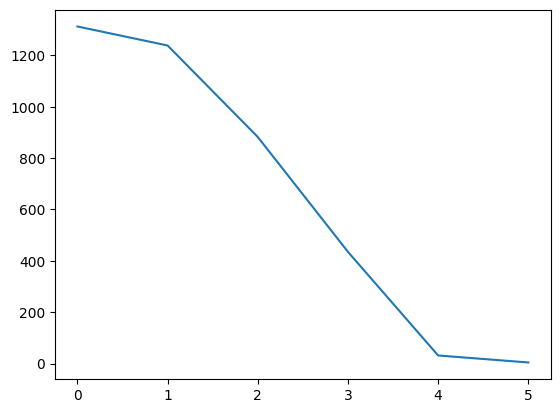

In [18]:
plt.plot(msr_Dcir)

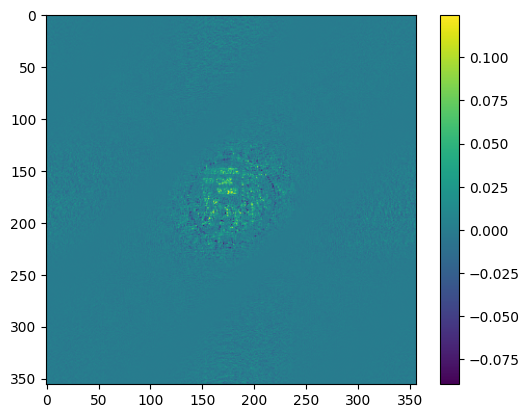

In [19]:
plt.imshow(Ics_mean_norm-Ica_norm)
plt.colorbar()

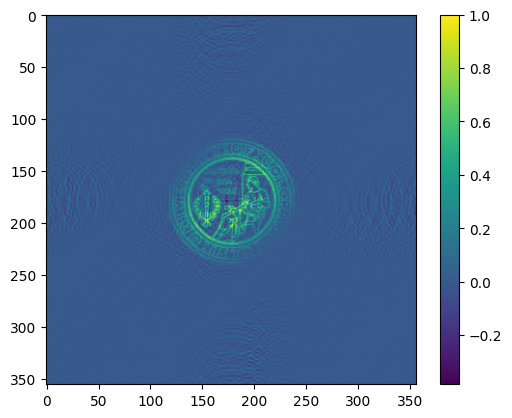

In [20]:
plt.imshow(Ica_norm)
plt.colorbar()

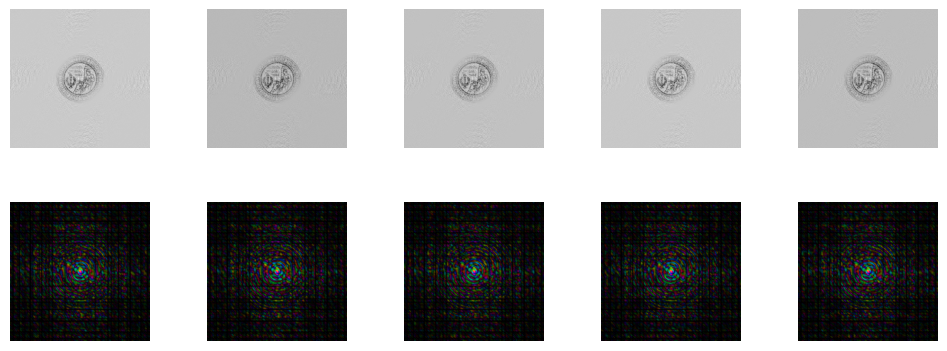

In [23]:
FT_Ics1 = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(Ics_stacks[:,:,0])))
FT_Ics2 = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(Ics_stacks[:,:,1])))
FT_Ics3 = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(Ics_stacks[:,:,2])))
FT_Ics4 = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(Ics_stacks[:,:,3])))
FT_Ics5 = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(Ics_stacks[:,:,4])))

c1 = 1
c2 = 0.0000001

FT_Ics1_log = imag_linear2log_v1(c1,c2,np.abs(FT_Ics1))
FT_Ics1_log_hsl = chsl.hsl_complex_v1(s0,l0,FT_Ics1_log*np.exp(1j*np.angle(FT_Ics1)))
FT_Ics2_log = imag_linear2log_v1(c1,c2,np.abs(FT_Ics2))
FT_Ics2_log_hsl = chsl.hsl_complex_v1(s0,l0,FT_Ics2_log*np.exp(1j*np.angle(FT_Ics2)))
FT_Ics3_log = imag_linear2log_v1(c1,c2,np.abs(FT_Ics3))
FT_Ics3_log_hsl = chsl.hsl_complex_v1(s0,l0,FT_Ics3_log*np.exp(1j*np.angle(FT_Ics3)))
FT_Ics4_log = imag_linear2log_v1(c1,c2,np.abs(FT_Ics4))
FT_Ics4_log_hsl = chsl.hsl_complex_v1(s0,l0,FT_Ics4_log*np.exp(1j*np.angle(FT_Ics4)))
FT_Ics5_log = imag_linear2log_v1(c1,c2,np.abs(FT_Ics5))
FT_Ics5_log_hsl = chsl.hsl_complex_v1(s0,l0,FT_Ics5_log*np.exp(1j*np.angle(FT_Ics5)))

fig,ax = plt.subplots(2,5,figsize=(10,4))
fig.tight_layout()

ax[0,0].imshow(np.real(Ics_stacks[:,:,0]),cmap='binary')
ax[0,0].axis('off')
ax[0,1].imshow(np.real(Ics_stacks[:,:,1]),cmap='binary')
ax[0,1].axis('off')
ax[0,2].imshow(np.real(Ics_stacks[:,:,2]),cmap='binary')
ax[0,2].axis('off')
ax[0,3].imshow(np.real(Ics_stacks[:,:,3]),cmap='binary')
ax[0,3].axis('off')
ax[0,4].imshow(np.real(Ics_stacks[:,:,4]),cmap='binary')
ax[0,4].axis('off')

ax[1,0].imshow(FT_Ics1_log_hsl)
ax[1,0].axis('off')
ax[1,1].imshow(FT_Ics2_log_hsl)
ax[1,1].axis('off')
ax[1,2].imshow(FT_Ics3_log_hsl)
ax[1,2].axis('off')
ax[1,3].imshow(FT_Ics4_log_hsl)
ax[1,3].axis('off')
ax[1,4].imshow(FT_Ics5_log_hsl)
ax[1,4].axis('off')
plt.savefig(fig_dir + f"temp/Speckled_image_stacks_v1.pdf", dpi=2000, bbox_inches='tight',transparent=True)
plt.show()

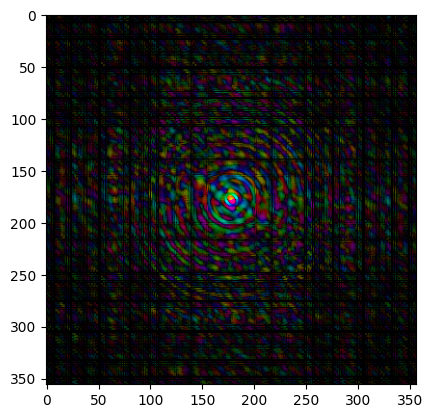

In [22]:
plt.imshow(FT_Ics3_log_hsl)
